# BA plots

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rdmulti import rdmc, rdms, rdmcplot


# plotting
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

# Set color cycle
cmap = plt.colormaps['Set3']
colors = cmap(np.linspace(0, 1, 5))   # 5 distinct colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
# import exceldata
df = pd.read_excel("Hjemsendelse 22-10-2025.xlsx", sheet_name="kvm_data")

#gen bs/sqm variable
df['bs_per_sqm'] = df['bs'] / df['sqm']

df.head(5)

,sqm,N,alder,ind,bs,leje,bs_per_sqm
0,41,14948,27.586098,138862.067335,488.080627,36429.203125,11.904406
1,42,18101,28.236064,140949.084549,503.692444,38265.359375,11.992677
2,43,16705,28.400539,141539.168001,509.922760,38417.808594,11.858669
3,44,17706,28.266915,146337.147782,512.827332,38426.824219,11.655167
4,45,18682,29.269778,149406.023504,517.209412,38610.585938,11.493542


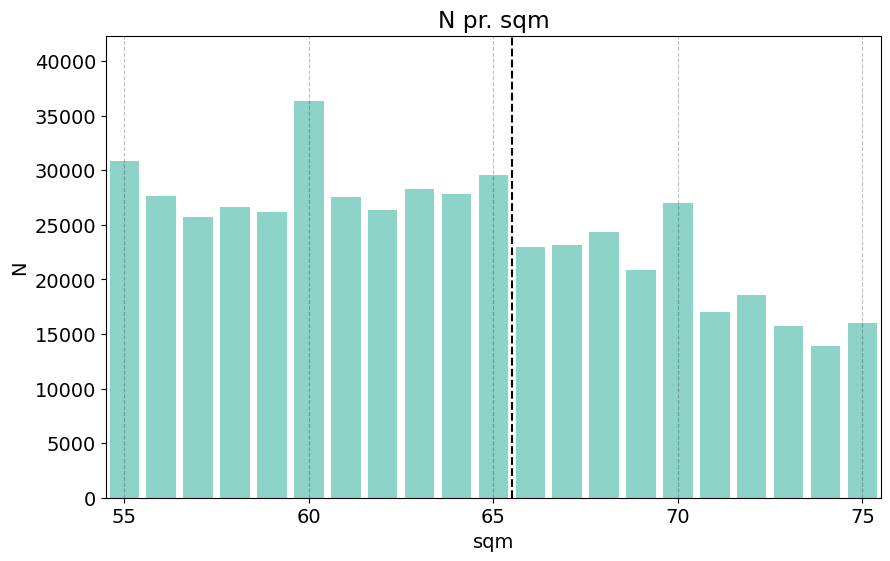

In [47]:
#Plot N on sqm
df = df.sort_values(by="sqm")

#make dotted line between bars 65 sqm and 66 sqm

plt.figure(figsize=(10,6))
plt.xlim(54.5, 75.5) # limit x-axis to 55-75 sqm
plt.xticks(np.arange(55, 76, 5))  # limit x-axis to 55-75 sqm
plt.bar(df['sqm'], df['N'])
plt.title('N pr. sqm')
plt.xlabel('sqm')
plt.ylabel('N')
plt.grid(axis='y')
x1 = 65
x2 = 66
midpoint = (x1 + x2) / 2
plt.axvline(x=midpoint, color='black', linestyle='--')
plt.show()

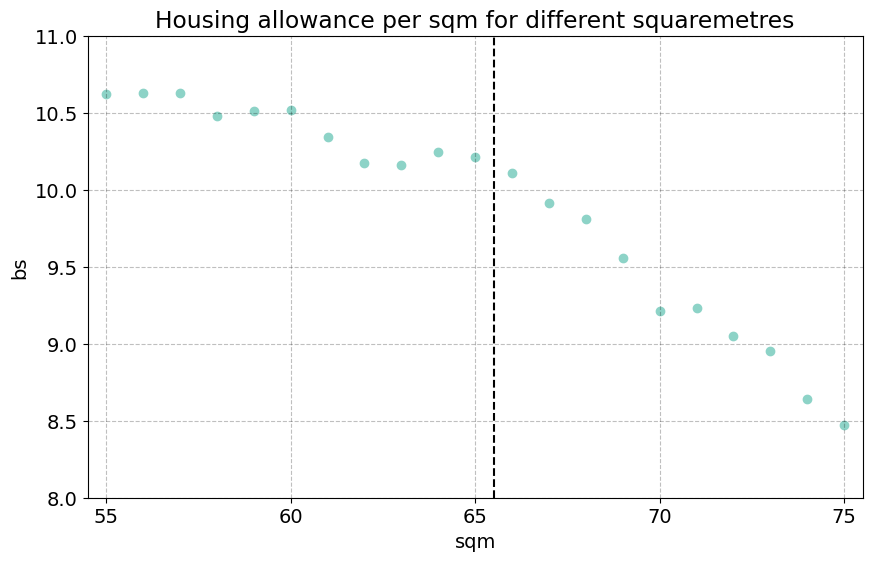

In [55]:
plt.figure(figsize=(10,6))

# scatter (dots) instead of bars
plt.scatter(df['sqm'], df['bs_per_sqm'])

plt.title('Housing allowance per sqm for different squaremetres')
plt.xlabel('sqm')
plt.ylabel('bs')
plt.grid(True)

# dotted separator between 65 and 66 sqm
x1 = 65
x2 = 66
midpoint = (x1 + x2) / 2
plt.axvline(x=midpoint, color='black', linestyle='--') # vertical dotted line

plt.ylim(8, 11) # limit y-axis
plt.xlim(54.5, 75.5) # limit x-axis
plt.xticks(np.arange(55, 76, 5))

plt.show()

/var/folders/fl/qg5hrzdx3ls1rmd_4w6mlrcw0000gn/T/ipykernel_37815/692243229.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/fl/qg5hrzdx3ls1rmd_4w6mlrcw0000gn/T/ipykernel_37815/692243229.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


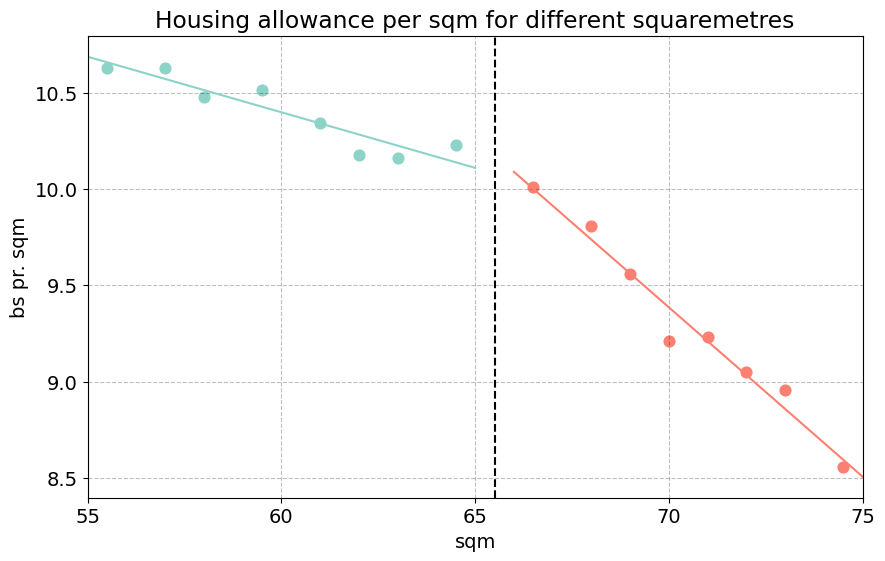

In [65]:
import statsmodels.api as sm

# --- 1. Subset for RD window ---
df_left = df[(df['sqm'] >= 55) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 66) & (df['sqm'] <= 75)].copy()

# --- 2. Binscatter means ---
def binscatter(data, x, y, bins=8):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bins)
    out = data.groupby('bin').agg(mean_x=(x, 'mean'), mean_y=(y, 'mean')).dropna()
    return out

bin_left = binscatter(df_left, 'sqm', 'bs_per_sqm', bins=8)
bin_right = binscatter(df_right, 'sqm', 'bs_per_sqm', bins=8)

# --- 3. Two separate regressions ---
def linreg(df_bin):
    X = sm.add_constant(df_bin['mean_x'])
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model.params['const'], model.params['mean_x']

a_L, b_L = linreg(bin_left)
a_R, b_R = linreg(bin_right)

# --- 4. Plot ---
plt.figure(figsize=(10,6))

# binscatter points
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=60)
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=60)

# left regression line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max(), 100)
yL = a_L + b_L * xL
plt.plot(xL, yL)

# right regression line
xR = np.linspace(df_right['sqm'].min(), df_right['sqm'].max(), 100)
yR = a_R + b_R * xR
plt.plot(xR, yR)

# --- 5. Cutoff line ---
cut = (65 + 66) / 2
plt.axvline(x=cut, linestyle='--', color='black')

# Aesthetics
plt.xlabel('sqm')
plt.ylabel('bs pr. sqm')
plt.title('Housing allowance per sqm for different squaremetres')
plt.grid(True)
plt.xticks(np.arange(55, 76, 5))
plt.xlim(55, 75)

plt.show()

/var/folders/fl/qg5hrzdx3ls1rmd_4w6mlrcw0000gn/T/ipykernel_37815/961590890.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/var/folders/fl/qg5hrzdx3ls1rmd_4w6mlrcw0000gn/T/ipykernel_37815/961590890.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


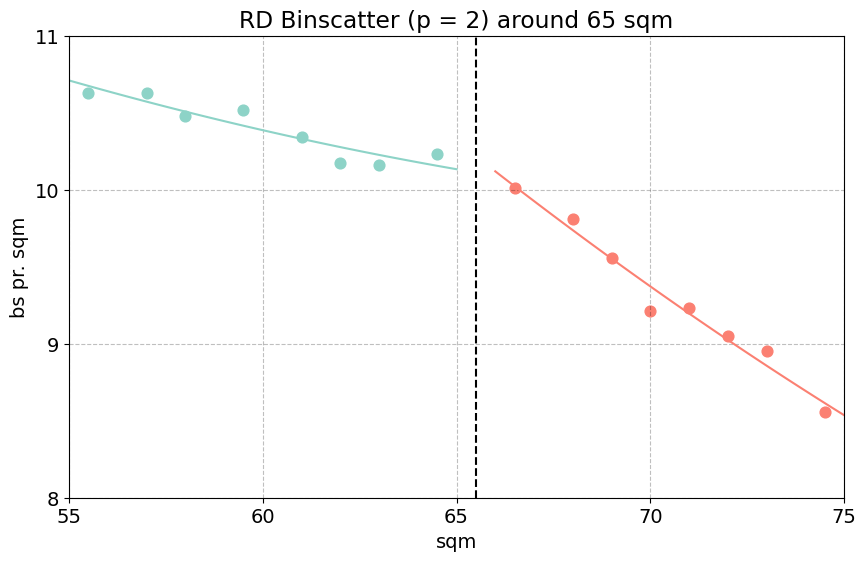

In [76]:


# --- 1. Subset for RD window (55–75 sqm, change if needed) ---
df_left = df[(df['sqm'] >= 55) & (df['sqm'] <= 65)].copy()
df_right = df[(df['sqm'] >= 66) & (df['sqm'] <= 75)].copy()

# --- 2. Binscatter helper ---
def binscatter(data, x, y, bins=8):
    data = data.copy()
    data['bin'] = pd.cut(data[x], bins=bins)
    return data.groupby('bin').agg(mean_x=(x, 'mean'),
                                   mean_y=(y, 'mean')).dropna()

bin_left = binscatter(df_left, 'sqm', 'bs_per_sqm', bins=8)
bin_right = binscatter(df_right, 'sqm', 'bs_per_sqm', bins=8)

# --- 3. Polynomial regression (p = 2) on each side ---
def poly_reg(df_bin):
    df_bin = df_bin.copy()
    df_bin['x2'] = df_bin['mean_x']**2               # quadratic term
    X = sm.add_constant(df_bin[['mean_x', 'x2']])    # const + x + x^2
    y = df_bin['mean_y']
    model = sm.OLS(y, X).fit()
    return model

model_L = poly_reg(bin_left)
model_R = poly_reg(bin_right)

# Extract coefficients
a_L = model_L.params['const']
b_L1 = model_L.params['mean_x']
b_L2 = model_L.params['x2']

a_R = model_R.params['const']
b_R1 = model_R.params['mean_x']
b_R2 = model_R.params['x2']

# --- 4. Plot binscatter + polynomial fit ---
plt.figure(figsize=(10,6))

# Scatter points (binned means)
plt.scatter(bin_left['mean_x'], bin_left['mean_y'], s=60)
plt.scatter(bin_right['mean_x'], bin_right['mean_y'], s=60)

# Left polynomial line
xL = np.linspace(df_left['sqm'].min(), df_left['sqm'].max(), 100)
yL = a_L + b_L1*xL + b_L2*xL**2
plt.plot(xL, yL)

# Right polynomial line
xR = np.linspace(df_right['sqm'].min(), df_right['sqm'].max(), 100)
yR = a_R + b_R1*xR + b_R2*xR**2
plt.plot(xR, yR)

# --- Cutoff line ---
cut = (65 + 66) / 2  # halfway between bins
plt.axvline(x=cut, linestyle='--', color='black')

# Formatting
plt.xlabel('sqm')
plt.ylabel('bs pr. sqm')
plt.title('RD Binscatter (p = 2) around 65 sqm')
plt.grid(True)
plt.xticks(np.arange(55, 76, 5))
plt.xlim(55, 75)
plt.ylim(8, 11)
plt.yticks(np.arange(8, 11.0000001, 1))

plt.show()